# Imports

In [753]:
import pandas as pd
import os
import re
from string import punctuation
import gensim.downloader as api
import random
import nltk
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from kneed import KneeLocator
from sklearn import datasets  # to retrieve the iris Dataset
from sklearn.preprocessing import StandardScaler  # to standardize the features
import seaborn as sns  # to plot the heat maps
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
import scipy.spatial as sp
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance
from gap_statistic import OptimalK
import copy
import numpy as np
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from statistics import mode
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from k_means_constrained import KMeansConstrained
from sklearn.metrics import davies_bouldin_score

# Helper Functions

In [3]:
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # Remove punctuation
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines
    return text

# Data Import

In [591]:
# Read in data
raw_data = pd.read_csv ('ADDRESS_TO_DATA')
raw_data['order']=np.arange(len(raw_data))

In [593]:
raw_data=raw_data[['order','subject_id', 'stimulus', 'response', 
             'trial_type', 'Sample']]

# Removing useless trial types
raw_data=raw_data.dropna(subset=['trial_type'])

# Reset indexing
raw_data=raw_data.reset_index(drop=True)

In [595]:
def count_duplicates(x, cutoff=(12*11/3)*2):
    responses = set(x)
    return len(responses) > cutoff

# Cleaning out bad participant data
cutouts = raw_data[raw_data.trial_type == "associations"].groupby('subject_id').stimulus.apply(count_duplicates)
participants_to_keep = []
for k,v in zip(list(cutouts.index), list(cutouts.values)):
    print(k,v)
    if v == True:
        participants_to_keep.append(k)
data = raw_data[raw_data.subject_id.isin(participants_to_keep)]
clean_ids=data.drop_duplicates(subset=['subject_id']).subject_id
clean_ids=clean_ids.sort_values().reset_index(drop=True)

5240000 True
22100000 True
32228299 True
32535134 False
32535139 True
32535140 True
32535141 True
32535144 True
32535146 False
32970179 True
34000000 True
36518889 False
36799224 True
36827828 True
37000000 False
38889077 False
41032915 True
41197192 True
41595411 True
46100000 True
49321755 True
51785053 False
59523290 False
60203853 False
64709181 True
65807409 True
65937616 True
66997320 True
68281707 True
72138736 True
75241911 True
83586175 True
85454513 True
87030658 True
87030659 True
88349928 False
89439052 True
89962174 True
96509050 True
97542198 False


In [599]:
# Grab the word associations from the data
associatedwords_df = data[data.trial_type == "associations"]
associatedwords_df = associatedwords_df.sort_values(by=['subject_id', 'order'], ascending=[True, True]).reset_index(drop=True)

In [603]:
#ANEW
anew=pd.read_csv('./data/anew.csv')
# Grabbing the effort responses with Marta black magic nonsense
effort_last = pd.DataFrame()
effort_value=[]
effort_word=[]
effort_ID=[]
x=data[data.trial_type=="associations"].reset_index(drop=True)

x=x.sort_values(by=['subject_id','order'], ascending=[True, True]).reset_index()

for meme in range(len(x)): 
    if x.stimulus.iloc[meme] in anew.term.values:
        effort_value.append(int(anew[anew.term==x.iloc[meme].stimulus].pleasure.iloc[0]))
        effort_word.append(x.iloc[meme].stimulus)
        effort_ID.append(x.iloc[meme].subject_id)

effort_last["effort_value"]=effort_value
effort_last["effort_word"]=effort_word
effort_last["effort_ID"]=effort_ID

pain pain
quiet quiet
desire desire
desire desire
desire desire
food food
food food
heart heart
good good
win win
win win
win win
thoughtful thoughtful
thoughtful thoughtful
food food
world world
fall fall
color color
troubled troubled
troubled troubled
failure failure
failure failure
time time
beautiful beautiful
beautiful beautiful
spouse spouse
friend friend
hard hard
present present
present present
gift gift
time time
pain pain
hurt hurt
circus circus
lion lion
spouse spouse
happy happy
house house
cow cow
ketchup ketchup
stress stress
danger danger
life life
money money
pressure pressure
diamond diamond
pity pity
city city
car car
seat seat
heart heart
kids kids
book book
money money
time time
failure failure
success success
tool tool
time time
paradise paradise
vacation vacation
free free
annoy annoy
kids kids
kick kick
fun fun
scream scream
beautiful beautiful
wife wife
love love
home home
family family
family family
time time
win win
success success
pain pain
pain pain
pain pai

In [604]:
#ANEW
effort_counter=0
effort=[]

for i in range(len(associatedwords_df)):
    if effort_counter<len(effort_last):
        if associatedwords_df.iloc[i].subject_id==effort_last.iloc[effort_counter].effort_ID and associatedwords_df.iloc[i].stimulus==effort_last.iloc[effort_counter].effort_word:
            effort.append(effort_last["effort_value"].iloc[effort_counter])
            effort_counter=effort_counter+1
        else:
            effort.append(np.nan)
    else:
        effort.append(np.nan)
print(len(associatedwords_df), len(effort))

3960 3960


In [605]:
# Grabbing the pathology responses with more Marta black magic nonsense
pathology_last = pd.DataFrame()
pathology_value=[]
pathology_word=[]
pathology_ID=[]
x=data[data.trial_type=="associations"].reset_index(drop=True)

x=x.sort_values(by=['subject_id','order'], ascending=[True, True]).reset_index()


y=data[data.trial_type=="pathology"].reset_index()

y=y.sort_values(by=['subject_id','order'], ascending=[True, True]).reset_index()

for meme in range(len(y)): 
    if y.stimulus.iloc[meme] in x.stimulus.values:
        pathology_value.append(int(y.iloc[meme].response))
        pathology_word.append(y.iloc[meme].stimulus)
        pathology_ID.append(y.iloc[meme].subject_id)
    elif y.stimulus.iloc[meme] in x.response.values:
        print("check", y.stimulus.iloc[meme])
    else:
         print("out", y.stimulus.iloc[meme])

pathology_last["pathology_value"]=pathology_value
pathology_last["pathology_word"]=pathology_word
pathology_last["pathology_ID"]=pathology_ID

out not good
check desi
check america
check howdy
check toxic
check yay
check ok
check indian
out neurons
out tribulation
out nerves
out moment
out jealousy
out communicating
out wilderness
out motor
out crisis
out conveying
out neonatal
out ue
out input
out look forward
out newborn
out sensory
out messaging
out advice
out places
out signaling
out optimistic
out experiences
out adventure
out region
out early
out here
out situations
out telephone
out midlife
out descriptive
out premature
out soon
out signal
out healthy
out wipes
out warning
out function
out thirsty
out counter
out strong
out lunch
out weak
out crisis
out diaper
out panic
out hungry
out advice
out sloth
out hear
out jealousy
out breakfast
out morning
out voice
check elon
check pluto
check astronaut 
check italian
check adam
check eve
out on-time
check black eye
out c
check poppyseed
check decible
check cardiogram
out e
check t
check inal
check d
check six
check ti
check t
check amp
check lll
check champ
check A
out lern


In [606]:
pathology=[]

for person in clean_ids:
    tv_x=x[x.subject_id==person].reset_index()
    tv_pathology=pathology_last[pathology_last.pathology_ID==person].reset_index()
    
    for meme in range(len(tv_x)): 
        if tv_x.iloc[meme].stimulus in tv_pathology.pathology_word.values:
            pathology.append(tv_pathology[tv_pathology.pathology_word==tv_x.iloc[meme].stimulus].pathology_value.values[0])
        else:
            pathology.append(np.nan)
print(len(x), len(pathology))


3960 3960


In [608]:
# Make sure responses are lowercase
associatedwords_df['stimulus'] = associatedwords_df['stimulus'].str.lower()
data.stimulus = data.stimulus.str.lower()

/var/folders/dj/5120y4k977n6xm0qqrp1vvcc0000gn/T/ipykernel_97648/2414330944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.stimulus = data.stimulus.str.lower()


In [610]:
associatedwords_df['effort'] =  effort
associatedwords_df['pathology'] = pathology
associatedwords_df['stimulus'] = associatedwords_df['stimulus'].str.replace(' ', '')

In [612]:
associatedwords_df

,order,subject_id,stimulus,response,trial_type,Sample,effort,pathology
0,15122,5240000,pain,ass,associations,Gluket,24.0,100.0
1,15123,5240000,ass,no,associations,Gluket,NaN,81.0
2,15124,5240000,no,yes,associations,Gluket,NaN,71.0
3,15125,5240000,yes,begin,associations,Gluket,NaN,16.0
4,15126,5240000,begin,NaN,associations,Gluket,NaN,19.0
...,...,...,...,...,...,...,...,...
3955,10039,96509050,open,love,associations,Gluket,NaN,0.0
3956,10040,96509050,love,asnwers,associations,Gluket,98.0,0.0
3957,10041,96509050,answers,searching,associations,Gluket,NaN,16.0
3958,10042,96509050,searching,trials,associations,Gluket,NaN,36.0


# Model

### Embedding

In [42]:
model = api.load("glove-twitter-25");

### Semantic Distances

In [617]:
def compute_semantic_similarity(df):
    '''
    Takes in a dataframe and computes the semantic distances for word
    associations
    
    :param df: Dataframe containing the word associations
    '''
    df=df.reset_index()
    def preprocess(s):
        return [i.lower() for i in s.split()]
    def get_vector(s):
        return np.sum(np.array([model[i] for i in preprocess(s)]), axis=0)

        
    # Number of seed words used in task
    num_seed_words = 12
    # Number of word associations participants have to make
    num_word_associations = 11
    # List for semantic distances
    semantic_similarity= []
    
    # 
    for i in range(num_seed_words):
        semantic_similarity.append(0)
        for j in range(num_word_associations-1):
            #print(df.loc[(i*num_word_associations)+j].values[1])
            #print(df.loc[(i*num_word_associations)+j+1].values[1])
            s0 = df.loc[(i*num_word_associations)+j].values[1]
            s1 = df.loc[(i*num_word_associations)+j+1].values[1]
            semantic_similarity.append(1 - spatial.distance.cosine(get_vector(s0), get_vector(s1)))
            
    return semantic_similarity

In [619]:
def compute_semantic_distances(df):
    '''
    Takes in a dataframe and computes the semantic distances for word
    associations
    
    :param df: Dataframe containing the word associations
    '''
    df=df.reset_index()
    def preprocess(s):
        return [i.lower() for i in s.split()]
    def get_vector(s):
        return np.sum(np.array([model[i] for i in preprocess(s)]), axis=0)

        
    # Number of seed words used in task
    num_seed_words = 12
    # Number of word associations participants have to make
    num_word_associations = 11
    # List for semantic distances
    semantic_distances= []
    
    # 
    for i in range(num_seed_words):
        semantic_distances.append(0)
        for j in range(num_word_associations-1):
            #print(df.loc[(i*num_word_associations)+j].values[1])
            #print(df.loc[(i*num_word_associations)+j+1].values[1])
            s0 = df.loc[(i*num_word_associations)+j].values[1]
            s1 = df.loc[(i*num_word_associations)+j+1].values[1]
            print(distance.euclidean(get_vector(s0), get_vector(s1)))
            semantic_distances.append(distance.euclidean(get_vector(s0), get_vector(s1)))
            
    return semantic_distances

In [621]:
def vectorize(list_of_docs, wv=model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        #print(tokens)
        zero_vector = np.zeros(wv.vector_size)
        vectors = []
        if tokens in wv.key_to_index:
        # Generate the 25-dimensional vector for the input word
            vectors.append(wv[tokens])
            features.append(wv[tokens])
            now=tokens
            #print(f"Vector for '{tokens}':\n{features[-1:]}")
        else:
            print(now, features[-1:])
            print(f"'{tokens}' not found in vocabulary.")
    return features

In [623]:
associatedwords_df['word_vectors'] = associatedwords_df.groupby('subject_id').stimulus.transform(vectorize)

In [625]:
len(associatedwords_df['word_vectors'])

3960

### PCA

In [628]:
unique=associatedwords_df.drop_duplicates(subset=['subject_id']).subject_id

scaler = StandardScaler()
PCA_column=[]
PCA_person={}
for k in unique:
    temp=associatedwords_df[associatedwords_df.subject_id==k].word_vectors
    #print(k, len(associatedwords_df[associatedwords_df.subject_id==k]))

    df = pd.DataFrame()

    for i in range(25):
        column=[]
        for j in range(len(temp)):
            column.append(temp.values[j][i])
        df[i] = column

    scaler.fit(df)
    scaled_data = pd.DataFrame(scaler.fit_transform(df)) #scaling the data
    pca = PCA(n_components=3)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    pca_data = pd.DataFrame(pca_data,columns=['PC1','PC2','PC3'])
    pca_data.head()
    for l in range(12*11):
        now=[]
        for p in range(3):
            #print(l, p, pca_data.values[l][p])
            now.append(pca_data.values[l][p])
        now=np.array(now)
        PCA_column.append(now)

associatedwords_df["PCA"] = PCA_column

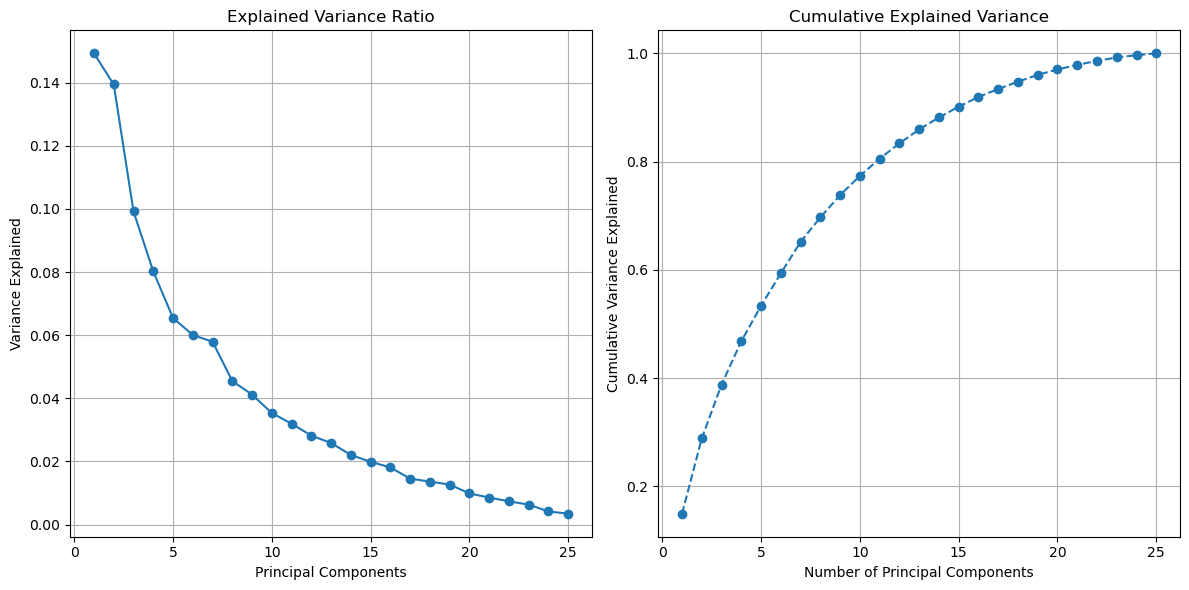

8


In [630]:
pca = PCA()
pca.fit(scaled_data)
    
# Get the explained variance ratios for all components
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratios and cumulative explained variance
plt.figure(figsize=(12, 6))

# Explained Variance Ratio Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.grid(True)

# Cumulative Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)

plt.tight_layout()
plt.show()

y=explained_variance_ratio
x=range(1, len(y)+1)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(kn.knee)

In [632]:
#add covariate of average "perceived pathology"
pathologyy={}
effortt={}

for i in unique:
    this=associatedwords_df[associatedwords_df.subject_id==i].reset_index()
    pathologyy[i]=this.pathology.mean(skipna=True)
    effortt[i]=this.effort.mean(skipna=True)
    
associatedwords_df["Avg_Pathology"] = associatedwords_df["subject_id"].map(pathologyy)
associatedwords_df["Avg_Effort"] = associatedwords_df["subject_id"].map(effortt)

In [634]:
enjchain=[]
pathchain=[]

for k in unique:
    thisonenow=associatedwords_df[associatedwords_df.subject_id==k]
    thisonenow=thisonenow.reset_index(drop=True)
    for i in range(12):
        #print(k, i, np.mean(thisonenow.pathology.iloc[i*11:(i*11+10)].dropna()))
        pathchain.append(np.mean(thisonenow.pathology.iloc[i*11:(i*11+10)].dropna()))
        enjchain.append(np.mean(thisonenow.effort.iloc[i*11:(i*11+10)].dropna()))

In [636]:
valence = []

for k in unique:
    thisonenow=copy.copy(associatedwords_df[associatedwords_df.subject_id==k])
    thisonenow=thisonenow.reset_index(drop=True)
    
    for i in range(12):
        word_now = thisonenow.stimulus.iloc[i*11]
        
        if (word_now == 'beautiful' or word_now == 'win' or word_now == 'father' or word_now == 'trip' or word_now == 'spouse' or word_now == 'heart' or word_now == 'future'):
           valence = np.append(valence, 2)
        elif (word_now == 'noise' or word_now == 'want' or word_now == 'teach' or word_now == 'breath' or word_now == 'advice' or word_now == 'beginning' or word_now == 'memory'):
           valence = np.append(valence, 1)
        else:
            valence = np.append(valence, 0)

array([0., 1., 2., 2., 1., 1., 0., 2., 2., 1., 0., 0., 0., 2., 1., 0., 0.,
       2., 1., 0., 1., 1., 2., 2., 0., 1., 1., 2., 0., 1., 2., 1., 0., 2.,
       0., 2., 1., 2., 1., 2., 0., 0., 1., 1., 2., 0., 0., 2., 0., 1., 1.,
       2., 0., 1., 1., 2., 2., 2., 0., 0., 2., 2., 0., 1., 1., 1., 2., 1.,
       2., 0., 0., 0., 0., 1., 2., 1., 0., 2., 0., 2., 2., 1., 1., 0., 1.,
       0., 0., 2., 1., 2., 1., 0., 1., 0., 2., 2., 2., 0., 0., 0., 1., 1.,
       1., 2., 2., 0., 2., 1., 2., 1., 0., 2., 0., 1., 2., 2., 1., 0., 1.,
       0., 2., 0., 1., 1., 1., 2., 0., 0., 0., 2., 1., 2., 0., 0., 1., 0.,
       1., 1., 2., 2., 2., 2., 0., 1., 2., 0., 1., 0., 0., 2., 2., 0., 1.,
       2., 1., 1., 1., 0., 0., 0., 2., 2., 1., 2., 1., 1., 2., 0., 2., 0.,
       1., 2., 0., 1., 1., 0., 2., 1., 0., 2., 2., 2., 0., 2., 0., 1., 1.,
       1., 2., 0., 1., 0., 1., 0., 2., 0., 1., 1., 0., 2., 2., 1., 2., 0.,
       0., 2., 0., 2., 1., 0., 2., 1., 1., 1., 2., 0., 2., 1., 2., 0., 2.,
       2., 0., 0., 1., 0.

Results

In [639]:
results = pd.read_csv ('/Users/martamigocortes/Desktop/Academics/Projectes/FASTwMDDs/tomerge/file.csv')
results

,Unnamed: 0,PCA_1,PCA_2,PCA_3,Slope,AIC,BIC,Similarity,SSE,subject_id
0,0,-1.893034,-8.719570,0.567391,0.788487,25.195591,26.787172,0.530145,52.516678,87030659
1,1,-5.591489,-6.148923,-3.440364,1.296989,22.247064,23.838645,0.484342,40.168491,87030659
2,2,0.957990,-2.156861,-0.034062,2.719421,30.045476,31.637058,0.074432,81.616341,87030659
3,3,31.656955,-76.178417,200.000000,0.013486,30.429979,32.021560,0.402174,84.519669,87030659
4,4,1.051309,0.737845,-0.443988,9.495169,28.262229,29.853811,0.467940,69.402023,87030659
...,...,...,...,...,...,...,...,...,...,...
355,7,2.099600,1.855397,1.939906,4.412177,30.014478,31.606059,0.250993,81.386665,89962174
356,8,2.373189,-2.120600,0.836318,2.397742,23.067702,24.659283,0.208553,43.279816,89962174
357,9,-33.072411,-200.000000,-177.283928,0.012463,26.870619,28.462200,0.519537,61.154659,89962174
358,10,113.878887,119.880765,200.000000,0.013858,28.440821,30.032402,0.673053,70.538010,89962174


In [641]:
results_clean = pd.DataFrame()
results_clean['ID']=results.subject_id
results_clean['Seed_Num']=results["Unnamed: 0"]
results_clean['PCA_1']=results.PCA_1
results_clean['PCA_2']=results.PCA_2
results_clean['PCA_3']=results.PCA_3
results_clean['Slope']=results.Slope
results_clean['AIC']=results.AIC
results_clean['Similarity']=results.Similarity

results_clean = results_clean.sort_values(by=['ID', 'Seed_Num'], ascending=[True, True]).reset_index(drop=True)

In [643]:
def compute_semantic_distances(word_one, word_two):
    '''
    Takes in two words and computes their semantic distanct
    
    :param df: Dataframe containing the word associations
    '''
    s0 = word_one
    s1 = word_two
    semantic_distances=math.dist(s0, s1)
            
    return semantic_distances

In [645]:
PCA_column=[]
for i in range(len(results_clean)):
    tv=[]
    for j in range(3):
        tv.append(results_clean.iloc[i][j+2])
    PCA_column.append(tv)
results_clean['PCA_column']=PCA_column

/var/folders/dj/5120y4k977n6xm0qqrp1vvcc0000gn/T/ipykernel_97648/2964197345.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tv.append(results_clean.iloc[i][j+2])


In [651]:
#Find words that are closest to Khat coordinates
distance_all={}
for i in unique:
    now_words=associatedwords_df[associatedwords_df.subject_id==i]
    now_words=now_words.reset_index(drop=True)
    now_attractor=results_clean[results_clean.ID==i]
    now_attractor=now_attractor.reset_index(drop=True)
    distance=[]
    for k in range(len(now_attractor)):
        word_two = now_attractor.PCA_column.iloc[k]
        word_two=np.array(word_two)
        for j in range(len(now_words)):
            word_one = np.array(now_words.PCA.iloc[j])
            if np.isnan(now_words.effort.iloc[j]) and np.isnan(now_words.pathology.iloc[j]):
                distance.append([k, compute_semantic_distances(word_one, word_two), now_words.stimulus.iloc[j]])
            elif np.isnan(now_words.pathology.iloc[j]):
                distance.append([k, compute_semantic_distances(word_one, word_two), now_words.stimulus.iloc[j], now_words.pathology.iloc[j], now_words.effort.iloc[j]])
            elif np.isnan(now_words.effort.iloc[j]):
                distance.append([k, compute_semantic_distances(word_one, word_two), now_words.stimulus.iloc[j], now_words.pathology.iloc[j], now_words.effort.iloc[j]])
            else:
                distance.append([k, compute_semantic_distances(word_one, word_two), now_words.stimulus.iloc[j], now_words.pathology.iloc[j], now_words.effort.iloc[j]])
        distance_all[i]=distance

In [653]:
#Find words that are closest to Khat coordinates
distance_ally=[]
for i in unique:
    now_words=associatedwords_df[associatedwords_df.subject_id==i]
    now_words=now_words.reset_index(drop=True)
    now_attractor=results_clean[results_clean.ID==i]
    now_attractor=now_attractor.reset_index(drop=True)
    for k in range(len(now_attractor)):
        distance=[]
        for j in range(10):
            word_one = now_words.PCA.iloc[k*11]
            word_one=np.array(word_two)
            word_two = np.array(now_words.PCA.iloc[k*11+j+1])
            distance.append(compute_semantic_distances(word_one, word_two))
        distance_ally.append(max(distance))
len(distance_ally)

360

In [655]:
results_clean["Semantic_Distance"] = results_clean["ID"].map(distance_all)
results_clean["Distance_TraveledInChain"] = distance_ally

In [663]:
def weighted_average(nums):
    weights=[]
    for l in range(len(nums)):
        weights.append((len(nums)**2)-((l+1)**2))
    return sum(x * y for x, y in zip(nums, weights)) / sum(weights)

#Get Weighted average of all words
    
avg_to_pathology={}
avg_to_enjoyment={}
for i in unique:
    count=0
    now_attractor=results_clean[results_clean.ID==i]
    now_attractor=now_attractor.reset_index(drop=True)
    row=[]
    rowtwo=[]
    for j in range(12):
        nowy=[]
        path_order=[]
        enjoy_order=[]
        now=now_attractor[now_attractor.Seed_Num==j]
        now=now.reset_index(drop=True)
        for k in range(12*11):
            if len(now.Semantic_Distance.iloc[0][k+(12*11*j)])==5:
                nowy.append(now.Semantic_Distance.iloc[0][k+(12*11*j)][1])
                path_order.append(now.Semantic_Distance.iloc[0][k+(12*11*j)][3])
                enjoy_order.append(now.Semantic_Distance.iloc[0][k+(12*11*j)][4])
        count=count+1
        nowy=np.array(nowy)
        path_order=np.array(path_order)
        enjoy_order=np.array(enjoy_order)
        df=pd.DataFrame()
        df['Distance']=nowy
        df['Enjoyment']=enjoy_order
        df['Path']=path_order
        df=df.sort_values(by=['Distance'])
        df=df.reset_index(drop=True)
        path_order=np.array(df.Path.dropna())
        avg_path=weighted_average(path_order)
        enjoy_order=np.array(df.Enjoyment.dropna())
        avg_enjoy=weighted_average(enjoy_order)
        row.append(avg_path)
        rowtwo.append(avg_enjoy)
    avg_to_pathology[i]=row
    avg_to_enjoyment[i]=rowtwo
    
travel_to_pathology=[]
avg_trav_to_path=[]
travel_to_enjoy=[]
avg_trav_to_enjoy=[]
now_path=[]
now_enjoy=[]

for i in unique:
    now_path=[]
    now_enjoy=[]
    for j in range(12):
        travel_to_pathology.append(avg_to_pathology[i][j])
        travel_to_enjoy.append(avg_to_enjoyment[i][j])
        now_path.append(avg_to_pathology[i][j])
        now_enjoy.append(avg_to_enjoyment[i][j])
    for k in range(12):
        avg_trav_to_path.append(np.nanmean(now_path))
        avg_trav_to_enjoy.append(np.nanmean(now_enjoy))

results_clean["Travel_to_Pathology"] = travel_to_pathology
results_clean["Avg_Travel_to_Pathology"] = avg_trav_to_path
results_clean["Travel_to_Enjoyment"] = travel_to_enjoy
results_clean["Avg_Travel_to_Enjoyment"] = avg_trav_to_enjoy

In [667]:
#Compute minimum and maximum distance between travel location and word chain
madeittocoordinate=[]
madeittocoordinate_min=[]
didntmakeittocoordinate=[]
didntmakeittocoordinate_max=[]
avg_dist_traveled=0
madeittocoordinate_person={}
avg_distance_to_coordinate={}
min_distance_to_coordinate={}
max_distance_to_coordinate={}
b_min=[]
b_max=[]
b_min_person={}
b_max_person={}

for i in unique:
    now_person=results_clean[results_clean.ID==i]
    now_person=now_person.reset_index(drop=True)
    now_chain=associatedwords_df[associatedwords_df.subject_id==i]
    now_chain=now_chain.reset_index(drop=True)
    distance_min=[]
    for j in range(12):
        distance_min=[]
        word_one=now_person.PCA_column.iloc[j]
        for k in range(11):
            word_two=now_chain.PCA.iloc[k+(j*11)]
            distance_min.append(compute_semantic_distances(word_one, word_two))
        madeittocoordinate.append(min(distance_min))
        madeittocoordinate_min.append(min(distance_min))
        didntmakeittocoordinate.append(max(distance_min))
        didntmakeittocoordinate_max.append(max(distance_min))
    avg_dist_traveled=np.mean(didntmakeittocoordinate)
    madeittocoordinate_person[i]=madeittocoordinate
    avg_distance_to_coordinate[i]=np.mean(madeittocoordinate)
    min_distance_to_coordinate[i]=min(madeittocoordinate)
    max_distance_to_coordinate[i]=max(madeittocoordinate)
    for j in range(12):
        if didntmakeittocoordinate[j]<=avg_dist_traveled:
            b_min.append(now_person.Slope.iloc[j])
        else:
                b_max.append(now_person.Slope.iloc[j])
    b_min_person[i]=np.mean(b_min)
    b_max_person[i]=np.mean(b_max)
    madeittocoordinate=[]
    didntmakeittocoordinate=[]
    b_min=[]
    b_max=[]


results_clean["Avg_Distanct_to_Location"]=results_clean.ID.map(avg_distance_to_coordinate)
results_clean["Min_Distance_to_Location"]=results_clean.ID.map(min_distance_to_coordinate)
results_clean["Max_Distance_to_Location"]=results_clean.ID.map(max_distance_to_coordinate)
results_clean["Min_Distance_to_Location_Chain"]=madeittocoordinate_min
results_clean["Max_Distance_to_Location_Chain"]=didntmakeittocoordinate_max

results_clean["Stuck_SmallDistanceTraveled"]=results_clean.ID.map(b_min_person)
results_clean["Stuck_BigDistanceTraveled"]=results_clean.ID.map(b_max_person)

In [671]:
#how similar are the coordinates where people get stuck? - All data
cos_all_person={}

for i in unique:
    now_person=associatedwords_df[associatedwords_df.subject_id==i]
    now_person=now_person.reset_index(drop=True)
    cos_now=[]
    for j in range(12*11):
        word_one=now_person.PCA.iloc[j]
        for k in range(12*11-1-j):
            word_two=now_person.PCA.iloc[k]
            cos_now.append(compute_semantic_distances(word_one, word_two))
    cos_all_person[i]=np.mean(cos_now)
results_clean['Revisiting_all']=results_clean.ID.map(cos_all_person)

In [673]:
#how similar are the coordinates where people get stuck? - where people tend towards
cos_person={}

for i in unique:
    now_person=results_clean[results_clean.ID==i]
    now_person=now_person.reset_index(drop=True)
    cos_now=[]
    for j in range(12):
        word_one=now_person.PCA_column.iloc[j]
        for k in range(11-j):
            word_two=now_person.PCA_column.iloc[k]
            cos_now.append(compute_semantic_distances(word_one, word_two))
    cos_person[i]=np.mean(cos_now)
results_clean['Revisiting']=results_clean.ID.map(cos_person)
print(cos_person)

{5240000: 13.147251270129791, 22100000: 12.243275919349388, 32228299: 27.070925934564627, 32535139: 94.51880518266708, 32535140: 105.95843925525978, 32535141: 90.25080194488858, 32535144: 66.52473102157262, 32970179: 95.43379582568046, 34000000: 92.82024297642528, 36799224: 67.21352067924424, 36827828: 55.242922201435626, 41032915: 63.4738525232552, 41197192: 81.60841007698589, 41595411: 46.4639399936188, 46100000: 75.69528724191804, 49321755: 11.753422669065918, 64709181: 30.7787468341814, 65807409: 86.55315972718836, 65937616: 55.46613425753141, 66997320: 133.71710671630768, 68281707: 37.25502919487455, 72138736: 69.65937783678905, 75241911: 70.51768107798883, 83586175: 124.92719569154704, 85454513: 6.741893007384506, 87030658: 60.422114403396435, 87030659: 101.53329400229829, 89439052: 85.04716525819893, 89962174: 151.8108634437385, 96509050: 101.39949607424109}


In [675]:
#create function to center data
center_function = lambda x: x - x.mean()

In [677]:
from sklearn import preprocessing

stand_function = lambda y:  preprocessing.scale(y)

In [679]:
results_clean['Path_chain']=pathchain
results_clean['Enj_chain']=enjchain

In [681]:
data_centered = center_function(results_clean['Slope'])
results_clean['Slope']=data_centered
data_centered = center_function(results_clean['Similarity'])
results_clean['Similarity']=data_centered
data_centered = center_function(results_clean['Revisiting'])
results_clean['Revisiting']=data_centered
data_centered = center_function(results_clean['Avg_Travel_to_Pathology'])
results_clean['Avg_Travel_to_Pathology']=data_centered
data_centered = center_function(results_clean['Travel_to_Pathology'])
results_clean['Travel_to_Pathology']=data_centered
data_centered = center_function(results_clean['Avg_Travel_to_Enjoyment'])
results_clean['Avg_Travel_to_Enjoyment']=data_centered
data_centered = center_function(results_clean['Travel_to_Enjoyment'])
results_clean['Travel_to_Enjoyment']=data_centered
data_centered = center_function(results_clean['Avg_Distanct_to_Location'])
results_clean['Avg_Distanct_to_Location']=data_centered
data_centered = center_function(results_clean['Min_Distance_to_Location'])
results_clean['Min_Distance_to_Location']=data_centered
data_centered = center_function(results_clean['Max_Distance_to_Location'])
results_clean['Max_Distance_to_Location']=data_centered
data_centered = center_function(results_clean['Min_Distance_to_Location_Chain'])
results_clean['Min_Distance_to_Location_Chain']=data_centered
data_centered = center_function(results_clean['Max_Distance_to_Location_Chain'])
results_clean['Max_Distance_to_Location_Chain']=data_centered
data_centered = center_function(results_clean['Distance_TraveledInChain'])
results_clean['Distance_TraveledInChain']=data_centered
data_centered = center_function(results_clean['AIC'])
results_clean['AIC']=data_centered

In [683]:
best_bw=[]

for j in unique:
        allwords=associatedwords_df[associatedwords_df["subject_id"]==j]
        X=list(allwords.PCA)
        bandwidths = 10 ** np.linspace(-1, 1, 100)
        gridy = GridSearchCV(KernelDensity(kernel='gaussian'),
                            {'bandwidth': bandwidths},
                            cv=LeaveOneOut())
        gridy.fit(X);
        best_bw.append(gridy.best_params_)
        print(gridy.best_params_)

{'bandwidth': 0.4430621457583881}
{'bandwidth': 0.6428073117284322}
{'bandwidth': 0.40370172585965547}
{'bandwidth': 0.6135907273413174}
{'bandwidth': 0.739072203352578}
{'bandwidth': 0.5590810182512224}
{'bandwidth': 0.5857020818056667}
{'bandwidth': 0.6734150657750824}
{'bandwidth': 0.5590810182512224}
{'bandwidth': 0.533669923120631}
{'bandwidth': 0.4229242874389499}
{'bandwidth': 0.4430621457583881}
{'bandwidth': 0.4430621457583881}
{'bandwidth': 0.4862601580065355}
{'bandwidth': 0.5857020818056667}
{'bandwidth': 0.6734150657750824}
{'bandwidth': 0.6135907273413174}
{'bandwidth': 0.4430621457583881}
{'bandwidth': 0.5590810182512224}
{'bandwidth': 0.6734150657750824}
{'bandwidth': 0.7054802310718644}
{'bandwidth': 0.4862601580065355}
{'bandwidth': 0.4229242874389499}
{'bandwidth': 0.6135907273413174}
{'bandwidth': 0.7054802310718644}
{'bandwidth': 0.464158883361278}
{'bandwidth': 0.5094138014816381}
{'bandwidth': 0.6135907273413174}
{'bandwidth': 0.5857020818056667}
{'bandwidth': 0.

In [684]:
best_bwb=[]

for j in unique:
        trynow=results_clean[results_clean["ID"]==j]
        x = list(trynow.PCA_column)
        bandwidths = 10 ** np.linspace(-1, 5, 100)
        grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                            {'bandwidth': bandwidths},
                            cv=LeaveOneOut())
        grid.fit(x);
        best_bwb.append(grid.best_params_)
        print(grid.best_params_)

{'bandwidth': 46.41588833612782}
{'bandwidth': 7.56463327554629}
{'bandwidth': 61.35907273413176}
{'bandwidth': 61.35907273413176}
{'bandwidth': 53.366992312063125}
{'bandwidth': 26.560877829466868}
{'bandwidth': 46.41588833612782}
{'bandwidth': 40.37017258596554}
{'bandwidth': 23.101297000831604}
{'bandwidth': 53.366992312063125}
{'bandwidth': 53.366992312063125}
{'bandwidth': 61.35907273413176}
{'bandwidth': 70.54802310718645}
{'bandwidth': 61.35907273413176}
{'bandwidth': 53.366992312063125}
{'bandwidth': 7.56463327554629}
{'bandwidth': 53.366992312063125}
{'bandwidth': 61.35907273413176}
{'bandwidth': 46.41588833612782}
{'bandwidth': 70.54802310718645}
{'bandwidth': 35.11191734215131}
{'bandwidth': 61.35907273413176}
{'bandwidth': 53.366992312063125}
{'bandwidth': 53.366992312063125}
{'bandwidth': 8.697490026177835}
{'bandwidth': 35.11191734215131}
{'bandwidth': 70.54802310718645}
{'bandwidth': 46.41588833612782}
{'bandwidth': 81.11308307896873}
{'bandwidth': 70.54802310718645}


In [687]:
kernel_density_iqr=[]
kernel_density=[]
kernel_density_TWA=[]
kernel_density=[]
bw_now=0

for j in unique:
        trynow=results_clean[results_clean["ID"]==j]
        allwords=associatedwords_df[associatedwords_df["subject_id"]==j]
        x = list(trynow.PCA_column)
        X=list(allwords.PCA)
        kde = KernelDensity(kernel="gaussian", bandwidth=best_bw[bw_now].get("bandwidth")).fit(X)
        bw_now=bw_now+1
        print(kde.score_samples(x))
        probabilities = kde.score_samples(x)
        probabilities = exp(probabilities)
        print(probabilities)
        for i in range(12):
            kernel_density_TWA.append(probabilities[i])
        
results_clean['Kernel_Density_TWA']=kernel_density_TWA
data_centered = center_function(results_clean['Kernel_Density_TWA'])
results_clean['Kernel_Density_TWA']=data_centered

[-7.66658312e+00 -5.55953845e+00 -6.02426742e+00 -9.50632082e+00
 -1.21941373e+02 -5.52460560e+00 -4.63455953e+00 -5.81471138e+00
 -4.75735563e+00 -7.07060263e+00 -2.21625513e+05 -5.92698919e+00]
[4.68214929e-04 3.85055323e-03 2.41932326e-03 7.43801972e-05
 1.10035946e-53 3.98744104e-03 9.71038321e-03 2.98334126e-03
 8.58828997e-03 8.49720891e-04 0.00000000e+00 2.66649822e-03]
[   -6.59187623   -30.43674158    -6.02502472 -1942.27804096
    -5.32838768    -5.43017838    -6.35661672    -5.01102234
    -5.38499582    -6.07217977   -50.0564651     -5.69933197]
[1.37146436e-03 6.04631938e-14 2.41749181e-03 0.00000000e+00
 4.85188649e-03 4.38231404e-03 1.73522755e-03 6.66408688e-03
 4.58485949e-03 2.30614088e-03 1.82286046e-22 3.34820140e-03]
[-1.11639790e+03 -6.13581369e+00 -1.19667289e+02 -7.70595308e+00
 -1.12535882e+01 -4.43617689e+00 -7.63474353e+02 -5.08324876e+00
 -3.16363231e+02 -2.25376334e+05 -5.08318879e+00 -1.36295593e+05]
[0.00000000e+000 2.16396370e-003 1.06944111e-052 4.50139

In [689]:
kernel_density_iqr=[]
kernel_density=[]
bw_now=0

for j in unique:
        trynow=results_clean[results_clean["ID"]==j]
        x = list(trynow.PCA_column)
        kde = KernelDensity(kernel="gaussian", bandwidth=best_bwb[bw_now].get("bandwidth")).fit(x)
        bw_now=bw_now+1
        densitynow=[]
        probabilities = kde.score_samples(x)
        probabilities = np.exp(probabilities)
        print(probabilities)
        for i in range(12):
            kernel_density.append(probabilities[i])
        counter=0
        q3, q1 = np.percentile(x, [75 ,25])
        iqr = q3 - q1
        maxnow=max(probabilities)
        for m in range(12):
            if round(probabilities[k],m)!=0:
                counter=m
                break
        for k in range(len(probabilities)):
            densitynow.append(round(probabilities[k],counter+2))
        count=0
        minimum=[]
        for p in range(12):
            minimum.append((probabilities[p]-mode(probabilities))*(probabilities[p]-mode(probabilities)))
            if round(probabilities[p], counter+2)== mode(densitynow):
                count=count+1
        sdnow=math.sqrt(sum(minimum)/len(minimum))
        for i in range(12):
            kernel_density_iqr.append(iqr)

        
results_clean['Kernel_Density']=kernel_density
data_centered = center_function(results_clean['Kernel_Density'])
results_clean['Kernel_Density']=data_centered

results_clean['Kernel_Density_IQR']=kernel_density_iqr
data_centered = center_function(results_clean['Kernel_Density_IQR'])
results_clean['Kernel_Density_IQR']=data_centered

[5.79239411e-07 5.79855208e-07 5.79708486e-07 5.78073032e-07
 5.65991454e-07 5.79652140e-07 5.79343910e-07 5.80010919e-07
 5.79187375e-07 5.78201335e-07 5.29113640e-08 5.79537405e-07]
[1.12950396e-04 7.18527152e-05 1.16775145e-04 1.22232490e-05
 1.16696458e-04 1.16681845e-04 1.15306328e-04 1.18693183e-04
 1.17756952e-04 1.13938158e-04 5.46189814e-05 1.13033755e-04]
[2.17351109e-07 2.26102070e-07 2.24929575e-07 2.25839654e-07
 2.25921637e-07 2.25649687e-07 2.20909711e-07 2.24751477e-07
 2.23555120e-07 2.29154755e-08 2.25149509e-07 2.32993293e-08]
[1.97548742e-07 2.37313372e-08 1.97849763e-07 1.97404238e-07
 1.97733857e-07 2.30727070e-08 1.97487525e-07 1.40702708e-07
 1.96996349e-07 1.97734475e-07 1.97348197e-07 2.31338274e-08]
[3.47229661e-07 3.49003535e-08 3.46560449e-07 3.48745377e-08
 3.47090269e-07 3.44015160e-07 3.47198015e-07 3.47248872e-07
 3.47237420e-07 3.45425088e-07 3.46991040e-07 3.46483559e-07]
[2.50823290e-06 3.21747147e-07 2.50434073e-06 2.52344704e-06
 2.51950345e-06 3.2

In [691]:
data_centered = stand_function(results_clean['Slope'])
results_clean['Slope']=data_centered
data_centered = stand_function(results_clean['Similarity'])
results_clean['Similarity']=data_centered
data_centered = stand_function(results_clean['Revisiting'])
results_clean['Revisiting']=data_centered
data_centered = stand_function(results_clean['Avg_Travel_to_Pathology'])
results_clean['Avg_Travel_to_Pathology']=data_centered
data_centered = stand_function(results_clean['Travel_to_Pathology'])
results_clean['Travel_to_Pathology']=data_centered
data_centered = stand_function(results_clean['Avg_Travel_to_Enjoyment'])
results_clean['Avg_Travel_to_Enjoyment']=data_centered
data_centered = stand_function(results_clean['Travel_to_Enjoyment'])
results_clean['Travel_to_Enjoyment']=data_centered
data_centered = stand_function(results_clean['Avg_Distanct_to_Location'])
results_clean['Avg_Distanct_to_Location']=data_centered
data_centered = stand_function(results_clean['Min_Distance_to_Location'])
results_clean['Min_Distance_to_Location']=data_centered
data_centered = stand_function(results_clean['Max_Distance_to_Location'])
results_clean['Max_Distance_to_Location']=data_centered
data_centered = stand_function(results_clean['Min_Distance_to_Location_Chain'])
results_clean['Min_Distance_to_Location_Chain']=data_centered
data_centered = stand_function(results_clean['Max_Distance_to_Location_Chain'])
results_clean['Max_Distance_to_Location_Chain']=data_centered
data_centered = stand_function(results_clean['Kernel_Density'])
results_clean['Kernel_Density']=data_centered
data_centered = stand_function(results_clean['Kernel_Density_TWA'])
results_clean['Kernel_Density_TWA']=data_centered
data_centered = stand_function(results_clean['Distance_TraveledInChain'])
results_clean['Distance_TraveledInChain']=data_centered
data_centered = stand_function(results_clean['AIC'])
results_clean['AIC']=data_centered

In [717]:
a_kernTWAmin=[]

for i in range(len(results_clean)):
    tv=[]
    tv.append(results_clean.Slope.iloc[i])
    tv.append(results_clean.Min_Distance_to_Location_Chain.iloc[i])
    tv.append(results_clean.Travel_to_Enjoyment.iloc[i])
    a_kernTWAmin.append(tv)

results_clean['A_MinDCEnj']=a_kernTWAmin

In [759]:
def mbkmeans_clusters(X, k, mb):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    return [k,km.inertia_,km]

In [761]:
now = []

for i in range(len(results_clean.A_MinDCEnj)):
    now.append(results_clean.A_MinDCEnj[i])
#now

In [763]:
silhouette_scores = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(np.array(now))
    silhouette_scores.append(silhouette_score(now, kmeans.labels_))
    
silhouette_scores

[0.494715703713001,
 0.5052649007743644,
 0.44838537317557675,
 0.3866710573016778,
 0.40813756759874836,
 0.4040829806867764,
 0.4055726367013831,
 0.41964071484610294,
 0.4080615916006492,
 0.38513685564686045,
 0.395632451830309,
 0.3925462031208113,
 0.38441864702425743,
 0.3723420939049852,
 0.3804168942980394,
 0.38482101776632166,
 0.374841301336298,
 0.3633197366498379,
 0.3538050022962412,
 0.370069385052203,
 0.3691675954166118,
 0.35903986743399247,
 0.3634991790836603]

In [765]:
db_scores = []
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(now)
    db_scores.append(davies_bouldin_score(now, kmeans.labels_))
db_scores

[0.785346783785565,
 0.7614494949414102,
 0.7347702435200294,
 0.8124521620573357,
 0.7835096502455934,
 0.7744686209744269,
 0.7672816654387199,
 0.7507379498994607,
 0.7741065253481959,
 0.8145078906736988,
 0.8083883222461382,
 0.8131321594034474,
 0.7937068160279279,
 0.8111516975117918,
 0.7762675166274585,
 0.7514449779492615,
 0.7760149492099452,
 0.7791857986233194,
 0.7971113744081152]

In [755]:
clf = KMeansConstrained(
     n_clusters=4,
     size_min=94,
     size_max=len(results_clean.A_MinDCEnj)-94*4,
     random_state=0
)

clf.fit_predict(now)
print(clf.cluster_centers_)
print(clf.labels_)

ValueError: size_min and size_max must be a positive number smaller than the number of data points or `None`

In [767]:
# Cluster all people, all word chains
participant_k_val=[]

import warnings
with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
        participant_k_all = []
        now_k=[]
        sure=0
        x = list(results_clean.A_MinDCEnj)
        
        for i in range(1,8):
            curr_k = mbkmeans_clusters(X=x,k=i,mb=1024);
            participant_k_all.append(curr_k)
            now_k.append(curr_k[1])
        y=now_k
        x=range(1, len(y)+1)
        kn = KneeLocator(x, y, curve='convex', direction='decreasing')
        participant_k = participant_k_all[kn.knee]
        now_k=[]
        sure=0
        print(participant_k)
        participant_k_val.append(participant_k)
print(participant_k[2].labels_)

[4, 298.5000408547602, MiniBatchKMeans(n_clusters=4)]
[0 0 0 2 2 0 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 1 2 1 3
 1 3 2 3 1 3 2 2 3 2 1 2 1 0 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 0 2 1 3 3 3
 3 3 1 2 3 1 0 3 3 1 2 2 2 2 1 2 0 1 2 1 2 2 0 1 2 2 1 2 2 2 2 2 2 2 2 2 1
 0 2 2 0 2 2 1 2 2 0 2 3 2 3 2 1 3 3 1 2 0 2 2 2 2 1 0 2 0 1 2 2 1 0 2 2 0
 1 1 2 2 0 2 2 1 3 3 3 3 3 3 3 3 3 1 3 3 2 2 2 1 2 2 2 1 0 2 0 0 3 3 3 0 3
 3 3 0 3 3 2 0 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 0
 1 2 2 2 0 2 2 1 2 0 2 1 2 1 3 2 1 2 0 0 2 2 3 1 2 2 2 0 2 3 0 2 2 2 2 2 1
 2 1 0 2 2 3 3 1 3 3 3 3 3 3 1 3 0 1 2 3 1 3 2 0 3 3 3 3 3 2 0 0 0 0 2 2 0
 2 2 2 0 2 1 2 3 0 2 0 2 2 0 2 2 3 3 3 3 3 1 3 3 2 1 3 3 2 2 0 1 2 2 3 3 1
 2 1 2 1 2 1 2 2 1 0 2 2 1 1 2 2 1 0 2 2 2 1 0 2 1 2 0]


In [769]:
optimal_k = OptimalK(parallel_backend='joblib')
n_clusters = optimal_k(np.array(now), cluster_array=np.arange(1, 8))

n_clusters

ModuleNotFoundError: No module named 'gap_statistic'

In [775]:
abv_clusters=[]

for p in range(len(participant_k[2].labels_)):
    abv_clusters.append(participant_k[2].labels_[p])
    
print(len(abv_clusters))
results_clean['ABV_clusters']=abv_clusters

360


In [777]:
results_clean['Valence'] = valence

In [781]:
data_centered = center_function(results_clean['Travel_to_Pathology'])
results_clean['Travel_to_Pathology']=data_centered

data_centered = center_function(results_clean['Travel_to_Enjoyment'])
results_clean['Travel_to_Enjoyment']=data_centered

zero=results_clean[results_clean.ABV_clusters==0]
print("Parameters: ", len(zero), np.mean(zero.Slope), np.mean(zero.Kernel_Density), np.mean(zero.Min_Distance_to_Location_Chain), np.mean(zero.Distance_TraveledInChain))
print("Trying things: ", np.mean(zero.Kernel_Density_TWA))
print("Ratings: ", np.mean(zero.Travel_to_Enjoyment), np.mean(zero.Travel_to_Pathology))
print("Fit: ", np.mean(zero.AIC))
one=results_clean[results_clean.ABV_clusters==1]
print("Parameters: ", len(one), np.mean(one.Slope), np.mean(one.Kernel_Density), np.mean(one.Min_Distance_to_Location_Chain), np.mean(one.Distance_TraveledInChain))
print("Trying things: ", np.mean(one.Kernel_Density_TWA))
print("Ratings: ", np.mean(one.Travel_to_Enjoyment), np.mean(one.Travel_to_Pathology))
print("Fit: ", np.mean(one.AIC))
two=results_clean[results_clean.ABV_clusters==2]
print("Parameters: ", len(two), np.mean(two.Slope), np.mean(two.Kernel_Density), np.mean(two.Min_Distance_to_Location_Chain), np.mean(two.Distance_TraveledInChain))
print("Trying things: ", np.mean(two.Kernel_Density_TWA))
print("Ratings: ", np.mean(two.Travel_to_Enjoyment), np.mean(two.Travel_to_Pathology))
print("Fit: ", np.mean(two.AIC))
three=results_clean[results_clean.ABV_clusters==3]
print("Parameters: ", len(three), np.mean(three.Slope), np.mean(three.Kernel_Density), np.mean(three.Min_Distance_to_Location_Chain), np.mean(three.Distance_TraveledInChain))
print("Trying things: ", np.mean(three.Kernel_Density_TWA))
print("Ratings: ", np.mean(three.Travel_to_Enjoyment), np.mean(three.Travel_to_Pathology))
print("Fit: ", np.mean(three.AIC))

print("0 v 1 Stuck: ", stats.ttest_ind(zero.Slope, one.Slope, equal_var=False))
print("1 v 2 Stuck: ", stats.ttest_ind(one.Slope, two.Slope, equal_var=False))
print("0 v 2 Stuck: ", stats.ttest_ind(zero.Slope, two.Slope, equal_var=False))
print("3 v 0 Stuck: ", stats.ttest_ind(three.Slope, zero.Slope, equal_var=False))
print("3 v 1 Stuck: ", stats.ttest_ind(three.Slope, one.Slope, equal_var=False))
print("3 v 2 Stuck: ", stats.ttest_ind(three.Slope, two.Slope, equal_var=False))

print("0 v 1 Min_Distance_to_Location: ", stats.ttest_ind(zero.Min_Distance_to_Location_Chain, one.Min_Distance_to_Location_Chain, equal_var=False))
print("1 v 2 Min_Distance_to_Location: ", stats.ttest_ind(one.Min_Distance_to_Location_Chain, two.Min_Distance_to_Location_Chain, equal_var=False))
print("0 v 2 Min_Distance_to_Location: ", stats.ttest_ind(zero.Min_Distance_to_Location_Chain, two.Min_Distance_to_Location_Chain, equal_var=False))
print("3 v 0 Min_Distance_to_Location: ", stats.ttest_ind(three.Min_Distance_to_Location_Chain, zero.Min_Distance_to_Location_Chain, equal_var=False))
print("3 v 1 Min_Distance_to_Location: ", stats.ttest_ind(three.Min_Distance_to_Location_Chain, one.Min_Distance_to_Location_Chain, equal_var=False))
print("3 v 2 Min_Distance_to_Location: ", stats.ttest_ind(three.Min_Distance_to_Location_Chain, two.Min_Distance_to_Location_Chain, equal_var=False))

print("0 v 1 Max_Distance_to_Location: ", stats.ttest_ind(zero.Max_Distance_to_Location_Chain, one.Max_Distance_to_Location_Chain, equal_var=False))
print("1 v 2 Max_Distance_to_Location: ", stats.ttest_ind(one.Max_Distance_to_Location_Chain, two.Max_Distance_to_Location_Chain, equal_var=False))
print("0 v 2 Max_Distance_to_Location: ", stats.ttest_ind(zero.Max_Distance_to_Location_Chain, two.Max_Distance_to_Location_Chain, equal_var=False))
print("3 v 0 Max_Distance_to_Location: ", stats.ttest_ind(three.Max_Distance_to_Location_Chain, zero.Max_Distance_to_Location_Chain, equal_var=False))
print("3 v 1 Max_Distance_to_Location: ", stats.ttest_ind(three.Max_Distance_to_Location_Chain, one.Max_Distance_to_Location_Chain, equal_var=False))
print("3 v 2 Max_Distance_to_Location: ", stats.ttest_ind(three.Max_Distance_to_Location_Chain, two.Max_Distance_to_Location_Chain, equal_var=False))

print("0 v 1 Kernel_Density: ", stats.ttest_ind(zero.Kernel_Density, one.Kernel_Density, equal_var=False))
print("1 v 2 Kernel_Density: ", stats.ttest_ind(one.Kernel_Density, two.Kernel_Density, equal_var=False))
print("0 v 2 Kernel_Density: ", stats.ttest_ind(zero.Kernel_Density, two.Kernel_Density, equal_var=False))
print("3 v 0 Kernel_Density: ", stats.ttest_ind(three.Kernel_Density, zero.Kernel_Density, equal_var=False))
print("3 v 1 Kernel_Density: ", stats.ttest_ind(three.Kernel_Density, one.Kernel_Density, equal_var=False))
print("3 v 2 Kernel_Density: ", stats.ttest_ind(three.Kernel_Density, two.Kernel_Density, equal_var=False))

print("0 v 1 Kernel_Density_TWA: ", stats.ttest_ind(zero.Kernel_Density_TWA, one.Kernel_Density_TWA, equal_var=False))
print("1 v 2 Kernel_Density_TWA: ", stats.ttest_ind(one.Kernel_Density_TWA, two.Kernel_Density_TWA, equal_var=False))
print("0 v 2 Kernel_Density_TWA: ", stats.ttest_ind(zero.Kernel_Density_TWA, two.Kernel_Density_TWA, equal_var=False))
print("3 v 0 Kernel_Density_TWA: ", stats.ttest_ind(three.Kernel_Density_TWA, zero.Kernel_Density_TWA, equal_var=False))
print("3 v 1 Kernel_Density_TWA: ", stats.ttest_ind(three.Kernel_Density_TWA, one.Kernel_Density_TWA, equal_var=False))
print("3 v 2 Kernel_Density_TWA: ", stats.ttest_ind(three.Kernel_Density_TWA, two.Kernel_Density_TWA, equal_var=False))

print("0 v 1 Revisiting: ", stats.ttest_ind(zero.Revisiting, one.Revisiting, equal_var=False))
print("1 v 2 Revisiting: ", stats.ttest_ind(one.Revisiting, two.Revisiting, equal_var=False))
print("0 v 2 Revisiting: ", stats.ttest_ind(zero.Revisiting, two.Revisiting, equal_var=False))
print("3 v 0 Revisiting: ", stats.ttest_ind(three.Revisiting, zero.Revisiting, equal_var=False))
print("3 v 1 Revisiting: ", stats.ttest_ind(three.Revisiting, one.Revisiting, equal_var=False))
print("3 v 2 Revisiting: ", stats.ttest_ind(three.Revisiting, two.Revisiting, equal_var=False))

print("0 v 1 Min_Distance_to_Location: ", stats.ttest_ind(zero.Min_Distance_to_Location, one.Min_Distance_to_Location, equal_var=False))
print("1 v 2 Min_Distance_to_Location: ", stats.ttest_ind(one.Min_Distance_to_Location, two.Min_Distance_to_Location, equal_var=False))
print("0 v 2 Min_Distance_to_Location: ", stats.ttest_ind(zero.Min_Distance_to_Location, two.Min_Distance_to_Location, equal_var=False))
print("3 v 0 Min_Distance_to_Location: ", stats.ttest_ind(three.Min_Distance_to_Location, zero.Min_Distance_to_Location, equal_var=False))
print("3 v 1 Min_Distance_to_Location: ", stats.ttest_ind(three.Min_Distance_to_Location, one.Min_Distance_to_Location, equal_var=False))
print("3 v 2 Min_Distance_to_Location: ", stats.ttest_ind(three.Min_Distance_to_Location, two.Min_Distance_to_Location, equal_var=False))

print("0 v 1 Travel_to_Enjoyment: ", stats.ttest_ind(zero.Travel_to_Enjoyment, one.Travel_to_Enjoyment, equal_var=False))
print("1 v 2 Travel_to_Enjoyment: ", stats.ttest_ind(one.Travel_to_Enjoyment, two.Travel_to_Enjoyment, equal_var=False))
print("0 v 2 Travel_to_Enjoyment: ", stats.ttest_ind(zero.Travel_to_Enjoyment, two.Travel_to_Enjoyment, equal_var=False))
print("3 v 0 Travel_to_Enjoyment: ", stats.ttest_ind(three.Travel_to_Enjoyment, zero.Travel_to_Enjoyment, equal_var=False))
print("3 v 1 Travel_to_Enjoyment: ", stats.ttest_ind(three.Travel_to_Enjoyment, one.Travel_to_Enjoyment, equal_var=False))
print("3 v 2 Travel_to_Enjoyment: ", stats.ttest_ind(three.Travel_to_Enjoyment, two.Travel_to_Enjoyment, equal_var=False))

print("0 v 1 Travel_to_Pathology: ", stats.ttest_ind(zero.Travel_to_Pathology, one.Travel_to_Pathology, equal_var=False))
print("1 v 2 Travel_to_Pathology: ", stats.ttest_ind(one.Travel_to_Pathology, two.Travel_to_Pathology, equal_var=False))
print("0 v 2 Travel_to_Pathology: ", stats.ttest_ind(zero.Travel_to_Pathology, two.Travel_to_Pathology, equal_var=False))
print("3 v 0 Travel_to_Pathology: ", stats.ttest_ind(three.Travel_to_Pathology, zero.Travel_to_Pathology, equal_var=False))
print("3 v 1 Travel_to_Pathology: ", stats.ttest_ind(three.Travel_to_Pathology, one.Travel_to_Pathology, equal_var=False))
print("3 v 2 Travel_to_Pathology: ", stats.ttest_ind(three.Travel_to_Pathology, two.Travel_to_Pathology, equal_var=False))

print("0 v 1 Fit: ", stats.ttest_ind(zero.Similarity, one.Similarity, equal_var=False))
print("1 v 2 Fit: ", stats.ttest_ind(one.Similarity, two.Similarity, equal_var=False))
print("0 v 2 Fit: ", stats.ttest_ind(zero.Similarity, two.Similarity, equal_var=False))
print("3 v 0 Fit: ", stats.ttest_ind(three.Similarity, zero.Similarity, equal_var=False))
print("3 v 1 Fit: ", stats.ttest_ind(three.Similarity, one.Similarity, equal_var=False))
print("3 v 2 Fit: ", stats.ttest_ind(three.Similarity, two.Similarity, equal_var=False))


for i in unique:
    person_now=results_clean[results_clean.ID==i]
    person_now=person_now.reset_index()
    cluster=mode(person_now.ABV_clusters)

Parameters:  51 2.0732178695076215 0.4249608333792268 -0.4913670813566859 0.028816903026207433
Trying things:  0.7835407171293017
Ratings:  0.31732289586744167 -0.08261947211024115
Fit:  0.3288499101214687
Parameters:  63 -0.8270687022000519 -0.32733602027409997 2.1038078145916477 -0.10469210958876397
Trying things:  -0.7713958785682253
Ratings:  0.12273268490488735 -0.09837885155556124
Fit:  -0.010654611927880914
Parameters:  179 -0.234464552755918 -0.018318081686624788 -0.4567828885568821 -0.07296310679675243
Trying things:  0.01850000754574814
Ratings:  0.4027080118898649 -0.116705869273961
Fit:  -0.16620264756895117
Parameters:  67 -0.17402430093994137 0.03325527457960523 -0.38382140475225207 0.27143786516976476
Trying things:  0.07949048396290852
Ratings:  -1.43284120845572 0.46719121381584583
Fit:  0.20373386641946042
0 v 1 Stuck:  TtestResult(statistic=29.1744487671539, pvalue=4.6389387060301244e-33, df=50.0002642103418)
1 v 2 Stuck:  TtestResult(statistic=-19.68415416976688, pv

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
